In [8]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
import dedalus.public as d3

import sys
sys.path.append("../../../dedalus_subroutines")
from isospectrum import isospectrum

In [13]:
snapname = '../2DEuler_snap/2DEuler_snap_s6.h5'
diagname = '../2DEuler_diag/2DEuler_diag_s1.h5'

with h5py.File(snapname, mode='r') as file:
    a_group_key = list(file.keys())
    print(a_group_key)
    
    print(file['scales'])
    print(list(file['scales']))
    print(file['tasks'])
    print(list(file['tasks']))

['scales', 'tasks']
<HDF5 group "/scales" (8 members)>
['constant', 'iteration', 'sim_time', 'timestep', 'wall_time', 'write_number', 'x_hash_8c7bfc8439e90bca80fc9c31418fd68fd237b7f7', 'y_hash_8c7bfc8439e90bca80fc9c31418fd68fd237b7f7']
<HDF5 group "/tasks" (2 members)>
['PSI', 'ZETA']


In [ ]:
with h5py.File(snapname, mode='r') as file:
    
    ZETA_data = np.squeeze(np.array(file['tasks']['ZETA']))
    print(ZETA_data.shape)
    PSI_data = np.squeeze(np.array(file['tasks']['PSI']))
    
    sim_time_ary = np.array(file['scales']['sim_time'])
    print(sim_time_ary)
    
    x = np.array(file['scales'][list(file['scales'])[-2]])
    y = np.array(file['scales'][list(file['scales'])[-1]])
    
with h5py.File(diagname, mode='r') as file:
    
    KE_data = np.squeeze(np.array(file['tasks']['KE']))
    Ens_data = np.squeeze(np.array(file['tasks']['Enstrophy']))
    print(Ens_data.shape)
    
    diag_time_ary = np.array(file['scales']['sim_time'])
#     print(diag_time_ary)

(50, 1024, 1024)


In [ ]:
time_idx = 0

fig=plt.figure(figsize=(11/1.7, 4/1.7))
# fig=plt.figure(figsize=(11, 4))
fig.suptitle('Time=%.2f' %(sim_time_ary[time_idx]), y=1.02)
plt.subplot(1, 2, 1)
plt.pcolormesh(x,y,ZETA_data[time_idx,:,:].T, cmap=cmo.balance, norm=colors.CenteredNorm())
plt.axis('equal')
cbar = plt.colorbar();
plt.title('Vorticity')

plt.subplot(1, 2, 2)
plt.contour(x,y,PSI_data[time_idx,:,:].T, cmap=cmo.balance, norm=colors.CenteredNorm())
plt.axis('equal')
cbar = plt.colorbar();
plt.title('Streamfunction')

figname = 'figs/2DEuler_zeta_t%.2f' %sim_time_ary[time_idx]
figname = figname.replace(".", "d" ); figname = figname+'.png'
plt.savefig(figname, bbox_inches='tight', dpi=400)
plt.show()

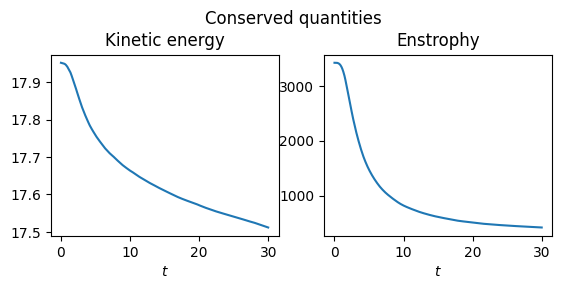

In [12]:
fig=plt.figure(figsize=(11/1.7, 4/1.7))
# fig=plt.figure(figsize=(11, 4))
fig.suptitle('Conserved quantities', y=1.07)
plt.subplot(1, 2, 1)
plt.plot(diag_time_ary[1:],KE_data[1:])
plt.xlabel('$t$')
plt.title('Kinetic energy')

# p.change_scales(1)
plt.subplot(1, 2, 2)
plt.plot(diag_time_ary[1:],Ens_data[1:])
plt.xlabel('$t$')
plt.title('Enstrophy')

plt.savefig('figs/2DEuler_energy.pdf', bbox_inches='tight')
plt.show()

OSError: Can't read data (addr overflow, addr = 805408, size = 3136, eoa = 599520)

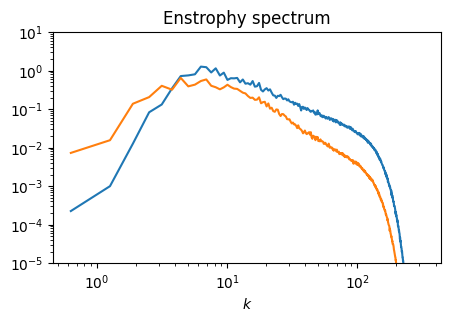

In [7]:
plt.figure(1,figsize=(5, 3))
plt.ylim([1e-5,1e1])
plt.title('Enstrophy spectrum')
plt.xlabel('$k$')


for inx in [2,4,6]:
#####
    snapname = '../2DEuler_snap/2DEuler_snap_s%i.h5' %inx
    diagname = '../2DEuler_diag/2DEuler_diag_s1.h5'


    with h5py.File(snapname, mode='r') as file:

        ZETA_data = np.squeeze(np.array(file['tasks']['ZETA']))
        sim_time_ary = np.array(file['scales']['sim_time'])

        x = np.array(file['scales'][list(file['scales'])[-2]])
        y = np.array(file['scales'][list(file['scales'])[-1]])

    # Numerics Parameters
    L = 10
    Lx, Ly = L, L
    Nx, Ny = ZETA_data.shape[2], ZETA_data.shape[2]

    dealias = 3/2
    dtype = np.float64

    #Physical Parameters
    alpha = 0.1
    planck = 1

    # Bases
    coords = d3.CartesianCoordinates('x', 'y')
    dist = d3.Distributor(coords, dtype=dtype)
    xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
    ybasis = d3.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=dealias)

    # Fields
    zeta = dist.Field(name='PV', bases=(xbasis,ybasis))

    time_idx = 0
    zeta['g'] = ZETA_data[time_idx,:,:]

    zeta_mag2d = zeta['c']*np.conj(zeta['c'])
    zeta_spec = isospectrum(zeta_mag2d)

    ######
    KK = xbasis.wavenumbers[2:-1:2]

    plt.figure(1)
    plt.loglog(KK,zeta_spec[1:],label="%.1f" %sim_time_ary[time_idx])

    
KK = xbasis.wavenumbers[2:-1:2]
plt.loglog(KK,KK**-1*6,color='k')
plt.axvline(KK[-1],color='k')
plt.legend()

plt.savefig('figs/2DEuler_spec.pdf', bbox_inches='tight')
plt.show()